In [36]:
from numpy import linalg as LA
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;
MU = 10
tau_incr = 2
tau_decr = 2

#for visualization purpose
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

#class for storing error norms for graphs later:
class record:
    r_norm = []
    s_norm = []
    objval_x = []
    objval_z = []
    eps_pri = []
    eps_dual = []
    z_record = []
    
    def __init__(self, n):
        self.r_norm = np.zeros(n)
        self.s_norm = np.zeros(n)
        self.objval_x = np.zeros(n)
        self.objval_z = np.zeros(n)
        self.eps_pri = np.zeros(n)
        self.eps_dual = np.zeros(n)
        self.z_record = np.zeros((n,3))

#this function projects x to the simple cone 0 <= sqrt(x^2+y^2) <= mu*z  
#IMPORTANT: x must be size (3,)!!
def projection_simple(x, mu = 1):
    if LA.norm(x) == 0:
        return x
    if np.sqrt(x[0]**2+x[1]**2) <= mu*x[2]:
        #inside the cone
        return x
    elif np.sqrt(x[0]**2+x[1]**2) <= -x[2]/mu:
        #inside polar cone
        return np.zeros(3)
    else:
        #project to the xyplane:
        t_hat = x[0:2]
        #normalize:
        t_hat = t_hat/LA.norm(t_hat)
        unit = np.append(mu*t_hat, 1)
        unit= unit/np.sqrt(1+mu**2)
        #now project to the ray:
        return np.inner(unit, x)*unit
        
#mu is parameter for cone projection
def quadprog(P, q, r, lb, ub, rho, alpha):
    n = P.shape[0]
    x = np.zeros(n)
    z = np.zeros(n)
    u = np.zeros(n)
    num_iter = 0
    history = record(MAX_ITER)
    rho_new = rho
    
    for k in range(MAX_ITER):
        if rho_new != rho or k== 0:
            rho = rho_new
            #print("rho changed to: ")
            #print(rho)
            R = LA.cholesky(P+rho*np.identity(n))
            x = LA.solve(np.transpose(R), (rho*(z - u) - q))
            x = LA.solve(R, x)
        else:
            #R =LA.cholesky(P+rho*np.identity(n))
            x = LA.solve(np.transpose(R), (rho*(z - u) - q))
            x = LA.solve(R, x)
        
        #z-update with relaxation
        zold = z
        x_hat = alpha*x + (1-alpha)*zold
        
        #projection to the cone:
        z = np.minimum(ub, np.maximum(lb, x_hat+u))
        #3D projection (uncomment for conic constraints and comment line above for conic constraints):
        #z = projection_simple(x_hat+u)
    
        u = u + (x_hat - z)

        history.r_norm[k] = LA.norm(x-z)
        history.s_norm[k] = LA.norm(-rho*(z - zold))
        history.objval_x[k] = objective(P, q, r, x)
        history.objval_z[k] = objective(P, q, r, z)
        history.eps_pri[k] = np.sqrt(n)*ABSTOL + RELTOL*np.maximum(LA.norm(x), LA.norm(-z))
        history.eps_dual[k] = np.sqrt(n)*ABSTOL + RELTOL*LA.norm(rho*u) 
        #update rho if two norms are very different:
        if history.r_norm[k] > MU*history.s_norm[k]:
            rho_new = rho*tau_incr
            u = u/tau_incr
        if history.s_norm[k] > MU*history.r_norm[k]:
            rho_new = rho/tau_decr
            u = u*tau_decr
        #stopping criterion:
        if (history.r_norm[k] < history.eps_pri[k] and history.s_norm[k] < history.eps_dual[k]):
            num_iter = k+1
            break
    
    return z, history, num_iter


#This version fixes rho for test purposes 
def quadprog_rho_fixed(P, q, r, lb, ub, rho, alpha):
    n = P.shape[0]
    x = np.zeros(n)
    z = np.zeros(n)
    u = np.zeros(n)
    num_iter = 0
    history = record(MAX_ITER)
    
    for k in range(MAX_ITER):
        if k== 0:
            R = LA.cholesky(P+rho*np.identity(n))
            x = LA.solve(np.transpose(R), (rho*(z - u) - q))
            x = LA.solve(R, x)
        else:
            #R =LA.cholesky(P+rho*np.identity(n))
            x = LA.solve(np.transpose(R), (rho*(z - u) - q))
            x = LA.solve(R, x)
        
        #z-update with relaxation
        zold = z
        x_hat = alpha*x + (1-alpha)*zold
        
        #projection to the cone:
        z = np.minimum(ub, np.maximum(lb, x_hat+u))
        #3D projection (uncomment for conic constraints and comment line above for conic constraints):
        #z = projection_simple(x_hat+u)
    
        u = u + (x_hat - z)

        history.r_norm[k] = LA.norm(x-z)
        history.s_norm[k] = LA.norm(-rho*(z - zold))
        history.objval_x[k] = objective(P, q, r, x)
        history.objval_z[k] = objective(P, q, r, z)
        history.eps_pri[k] = np.sqrt(n)*ABSTOL + RELTOL*np.maximum(LA.norm(x), LA.norm(-z))
        history.eps_dual[k] = np.sqrt(n)*ABSTOL + RELTOL*LA.norm(rho*u) 
        #stopping criterion:
        if (history.r_norm[k] < history.eps_pri[k] and history.s_norm[k] < history.eps_dual[k]):
            num_iter = k+1
            break
    
    return z, history, num_iter

#This version uses conic constraints. IMPORTANT: set n = 3 before using
#mu is parameter for cone projection
def quadprog_conic(P, q, r, rho, alpha, mu = 1):
    n = P.shape[0]
    x = np.zeros(n)
    z = np.zeros(n)
    u = np.zeros(n)
    num_iter = 0
    history = record(MAX_ITER)
    rho_new = rho
    
    for k in range(MAX_ITER):
        if rho_new != rho or k== 0:
            rho = rho_new
            #print("rho changed to: ")
            #print(rho)
            R = LA.cholesky(P+rho*np.identity(n))
            x = LA.solve(np.transpose(R), (rho*(z - u) - q))
            x = LA.solve(R, x)
        else:
            #R =LA.cholesky(P+rho*np.identity(n))
            x = LA.solve(np.transpose(R), (rho*(z - u) - q))
            x = LA.solve(R, x)
        
        #z-update with relaxation
        zold = z
        x_hat = alpha*x + (1-alpha)*zold
        
        #projection to the cone:
        #z = np.minimum(ub, np.maximum(lb, x_hat+u))
        #3D projection (uncomment for conic constraints and comment line above for conic constraints):
        z = projection_simple(x_hat+u)
        
        u = u + (x_hat - z)

        history.r_norm[k] = LA.norm(x-z)
        history.s_norm[k] = LA.norm(-rho*(z - zold))
        history.objval_x[k] = objective(P, q, r, x)
        history.objval_z[k] = objective(P, q, r, z)
        history.eps_pri[k] = np.sqrt(n)*ABSTOL + RELTOL*np.maximum(LA.norm(x), LA.norm(-z))
        history.eps_dual[k] = np.sqrt(n)*ABSTOL + RELTOL*LA.norm(rho*u) 
        history.z_record[i,:] = z
        #update rho if two norms are very different:
        if history.r_norm[k] > MU*history.s_norm[k]:
            rho_new = rho*tau_incr
            u = u/tau_incr
        if history.s_norm[k] > MU*history.r_norm[k]:
            rho_new = rho/tau_decr
            u = u*tau_decr
        #stopping criterion:
        if (history.r_norm[k] < history.eps_pri[k] and history.s_norm[k] < history.eps_dual[k]):
            num_iter = k+1
            break
    
    return z, history, num_iter
    
def objective(P, q, r, x):
    return 0.5*np.inner(x, P.dot(x))+np.inner(q, x)+r
    
    

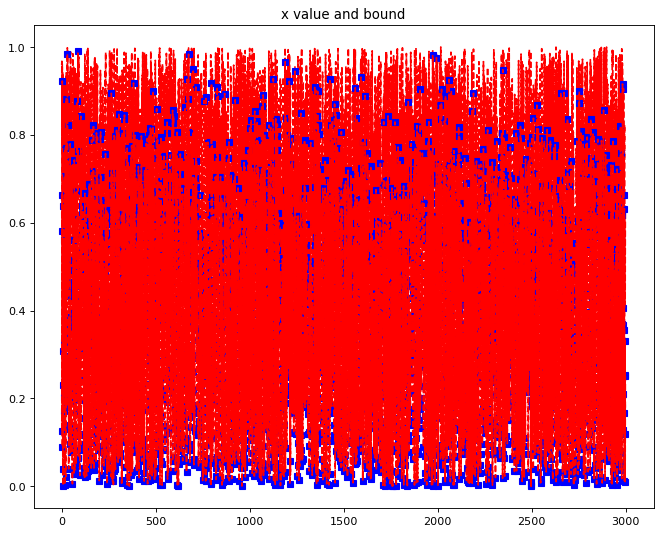

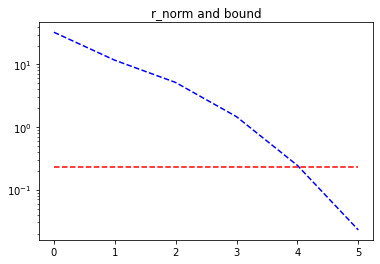

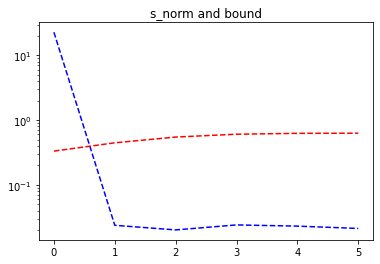

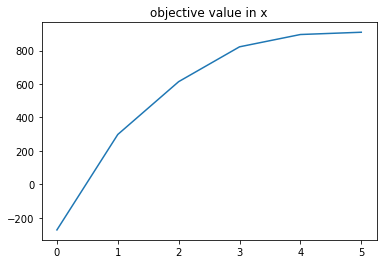

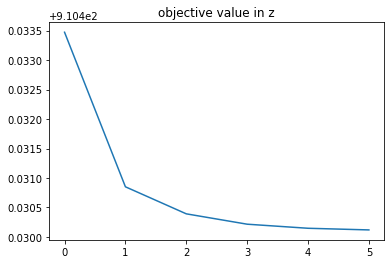

Avergae number of iterations taken for qp with adaptive rho:
5.5
Avergae number of iterations taken for qp with fixed rho:
10.5
Avergae number of iterations taken for qp with alpha = 1:
5.7
Avergae number of iterations taken for qp with alpha = 1.6:
4.3


In [51]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)

#size of the system:
n = 1000

P = np.random.rand(n,n)
P = P + np.transpose(P)
w,v = LA.eig(P) 
P = np.matmul(v, np.matmul(np.diag(np.ones(n)+np.random.rand(n)) , np.transpose(v)))
q = np.random.rand(n)
r = np.random.rand(1)
l = np.random.rand(n)
u = np.random.rand(n)
lb = np.minimum(l, u)
ub = np.maximum(l, u)

x,history,num_iter = quadprog(P, q, r, lb, ub, 1, 1.0)


#Tests:

#test1: visualize x, lb and ub, check if ub >= x >= lb
t = np.arange(0,n,1)
plt.plot(t, ub, 'r--', t, x, 'bs', t, lb, 'r--')
plt.title('x value and bound')
plt.show()
for i in range(n):
    if x[i] > ub[i] or x[i] < lb[i]:
        print("Error: Some entry of x is out of bound")

#test2: plot r_norm convergence w.r.t iterations
figure()
plt.plot(history.r_norm[0:num_iter], 'b--', history.eps_pri[0:num_iter], 'r--')
plt.title('r_norm and bound')
plt.yscale("log")
plt.show()

#test3: plot s_norm convergence w.r.t iterations
figure()
plt.plot(history.s_norm[0:num_iter], 'b--', history.eps_dual[0:num_iter], 'r--')
plt.yscale("log")
plt.title('s_norm and bound')
plt.show()

#test4: plot objective value w.r.t iterations
figure()
plt.plot(history.objval_x[0:num_iter])
plt.title('objective value in x')
plt.show()

#test5: plot objective value w.r.t iterations
figure()
plt.plot(history.objval_z[0:num_iter])
plt.title('objective value in z')
plt.show()

#test6: compare number of iterations taken by rho changing version and the fixed rho version of qp:
#We do qp 10 times and take avergae number of iteration for comparison
total_num_iter_fixed = 0
total_num_iter = 0
for i in range(10):
    P = np.random.rand(n,n)
    P = P + np.transpose(P)
    w,v = LA.eig(P) 
    P = np.matmul(v, np.matmul(np.diag(np.ones(n)+np.random.rand(n)) , np.transpose(v)))
    q = np.random.rand(n)
    r = np.random.rand(1)
    l = np.random.rand(n)
    u = np.random.rand(n)
    lb = np.minimum(l, u)
    ub = np.maximum(l, u)

    x,history,num_iter = quadprog(P, q, r, lb, ub, 1, 1.0)
    total_num_iter += num_iter
    
    x,history,num_iter = quadprog_rho_fixed(P, q, r, lb, ub, 1, 1.0)
    total_num_iter_fixed += num_iter
    
print("Avergae number of iterations taken for qp with adaptive rho:")
print(total_num_iter/10)
print("Avergae number of iterations taken for qp with fixed rho:")
print(total_num_iter_fixed/10)


#test7: compare number of iterations taken by alpha = 1.6 version and the alpha = 1 version of qp with adaptive rho:
total_num_iter_relaxed = 0
total_num_iter = 0
for i in range(10):
    P = np.random.rand(n,n)
    P = P + np.transpose(P)
    w,v = LA.eig(P) 
    P = np.matmul(v, np.matmul(np.diag(np.ones(n)+np.random.rand(n)) , np.transpose(v)))
    q = np.random.rand(n)
    r = np.random.rand(1)
    l = np.random.rand(n)
    u = np.random.rand(n)
    lb = np.minimum(l, u)
    ub = np.maximum(l, u)

    x,history,num_iter = quadprog(P, q, r, lb, ub, 1, 1.0)
    total_num_iter += num_iter
    
    x,history,num_iter = quadprog(P, q, r, lb, ub, 1, 1.6)
    total_num_iter_relaxed += num_iter
    
print("Avergae number of iterations taken for qp with alpha = 1:")
print(total_num_iter/10)
print("Avergae number of iterations taken for qp with alpha = 1.6:")
print(total_num_iter_relaxed/10)

TEST CASE: Point outside both cone and polar cone
Algebra check if projected point on the surface:
True
Algebra check if difference perpendicular to the projected point:
True
TEST CASE: Point inside cone
Algebra check if point identical to its projection:
True
TEST CASE: Point inside polar cone
Algebra check if projection at the origin:
True


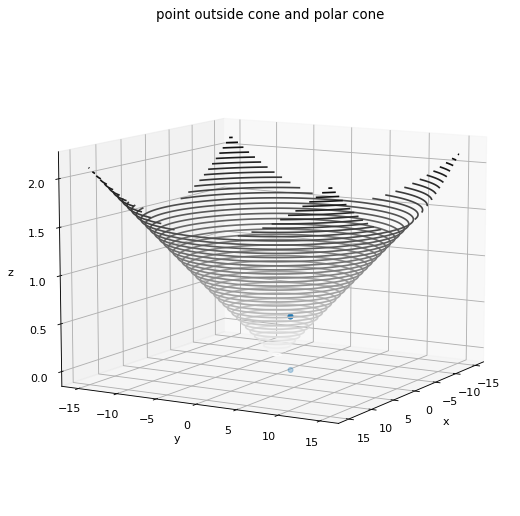

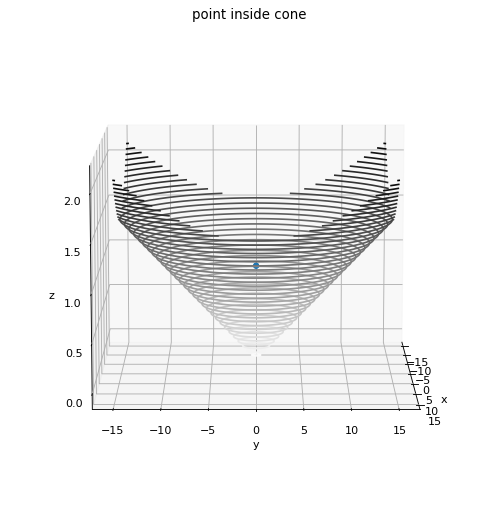

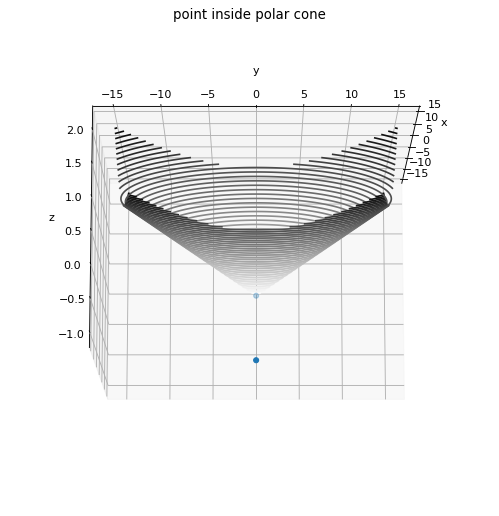

In [44]:
#test for simple 3D projection:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

mu = 10

#point outside both cone and polar cone:
figure(figsize=(10, 8), dpi=80)
ax = plt.axes(projection='3d')

x= np.linspace(-15, 15, 1000)
y = np.linspace(-15, 15, 1000)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(X**2+Y**2)/mu
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.view_init(10, 30)
p_out = np.array([[4,4,0], projection_simple([4,4,0], mu)])
ax.scatter3D(p_out[:,0],p_out[:,1],p_out[:,2], cmap='Reds');
ax.set_title('point outside cone and polar cone')
print("TEST CASE: Point outside both cone and polar cone")
print("Algebra check if projected point on the surface:")
print(np.allclose(projection_simple([4,4,0], mu)[0]**2+ projection_simple([4,4,0], mu)[1]**2, projection_simple([4,4,0], mu)[2]**2*mu*mu))
print("Algebra check if difference perpendicular to the projected point:")
print(np.allclose(np.inner(p_out[0, :] - p_out[1,:], p_out[1, :]), 0))

#point inside the cone:
figure(figsize=(10, 8), dpi=80)
ax = plt.axes(projection='3d')

x= np.linspace(-15, 15, 1000)
y = np.linspace(-15, 15, 1000)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(X**2+Y**2)/mu
ax.view_init(10, 0)
p_out = np.array([[0,0,1], projection_simple([0,0,1], mu)])

ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.scatter3D(p_out[:,0],p_out[:,1],p_out[:,2], cmap='Reds');
ax.set_title('point inside cone')
print("TEST CASE: Point inside cone")
print("Algebra check if point identical to its projection:")
print(np.allclose(p_out[0, :], p_out[1, :]))



#point inside the polar cone:
figure(figsize=(10, 8), dpi=80)
ax = plt.axes(projection='3d')
x= np.linspace(-15, 15, 1000)
y = np.linspace(-15, 15, 1000)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(X**2+Y**2)/mu
ax.view_init(-12, 0)
p_out = np.array([[0,0,-1], projection_simple([0,0,-1], mu)])

ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.scatter3D(p_out[:,0],p_out[:,1],p_out[:,2], cmap='Reds');
ax.set_title('point inside polar cone')
print("TEST CASE: Point inside polar cone")
print("Algebra check if projection at the origin:")
print(np.allclose(np.zeros(3), p_out[1, :]))




In [41]:
print(projection_simple([4,4,0], mu))
print(np.sqrt(3.96**2*2))

[3.96039604 3.96039604 0.56008458]
5.6002857069974565


Algebra check if solution inside the cone:
True


<Figure size 800x640 with 0 Axes>

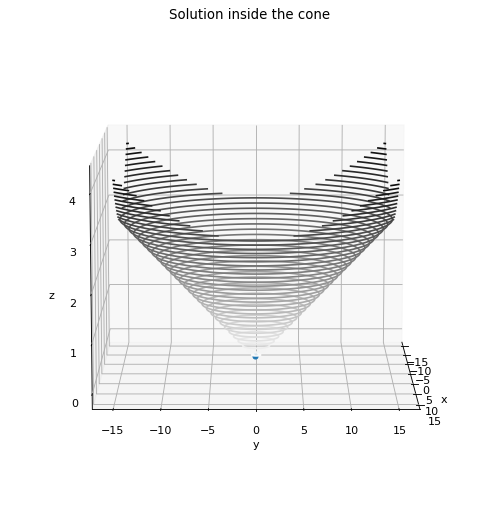

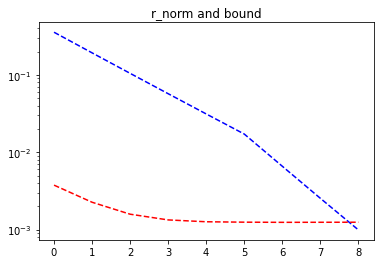

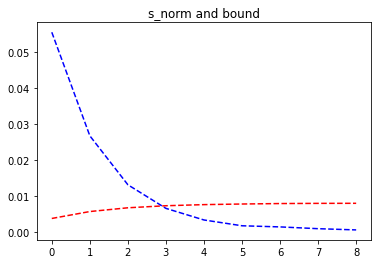

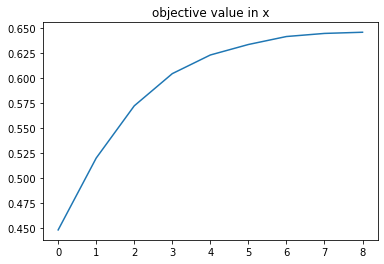

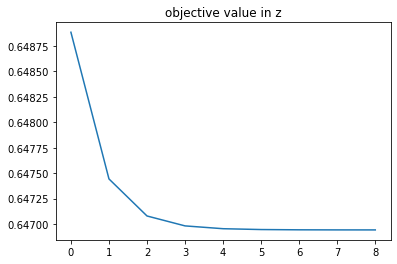

In [47]:
# Tests for qp with conic constraints:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random 

#random.seed(30)

figure(figsize=(10, 8), dpi=80)

#size of the system:
n = 3
mu = 5

P = np.random.rand(n,n)
P = P + np.transpose(P)
w,v = LA.eig(P) 
P = np.matmul(v, np.matmul(np.diag(np.ones(n)+np.random.rand(n)) , np.transpose(v)))
q = np.random.rand(n)
r = np.random.rand(1)

solution,history,num_iter = quadprog_conic(P, q, r, 1, 1.0, mu)



#Tests:

#test1: visualize solution vs the cone 
figure(figsize=(10, 8), dpi=80)
ax = plt.axes(projection='3d')
x= np.linspace(-15, 15, 1000)
y = np.linspace(-15, 15, 1000)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(X**2+Y**2)/mu
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.view_init(10, 0)
p_out = np.array([[4,4,0], projection_simple([4,4,0], mu)])
ax.scatter3D(solution[0], solution[1], solution[2], cmap='#ff7f0e');
#ax.scatter3D(history.z_record[:, 0], history.z_record[:, 1], history.z_record[:, 2], cmap='Greens');
ax.set_title('Solution inside the cone')
print("Algebra check if solution inside the cone:")
print(solution[0]**2 + solution[1]**2 <= solution[2])

#test2: plot r_norm convergence w.r.t iterations
figure()
plt.plot(history.r_norm[0:num_iter], 'b--', history.eps_pri[0:num_iter], 'r--')
plt.title('r_norm and bound')
plt.yscale("log")
plt.show()

#test3: plot s_norm convergence w.r.t iterations
figure()
plt.plot(history.s_norm[0:num_iter], 'b--', history.eps_dual[0:num_iter], 'r--')
#plt.yscale("log")
plt.title('s_norm and bound')
plt.show()
#figure()
#plt.plot(history.eps_dual[0:num_iter], 'r--')
#plt.show()

#test4: plot objective value w.r.t iterations
figure()
plt.plot(history.objval_x[0:num_iter])
plt.title('objective value in x')
plt.show()

#test5: plot objective value w.r.t iterations
figure()
plt.plot(history.objval_z[0:num_iter])
plt.title('objective value in z')
plt.show()


In [ ]:
#Irrelevant tests: used for checking matrix sizes etc

def isOrthogonal(a, m, n) :
    if (m != n) :
        return False
     
    trans = [[0 for x in range(n)]
                for y in range(n)]
                 
    # Find transpose
    for i in range(0, n) :
        for j in range(0, n) :
            trans[i][j] = a[j][i]
             
    prod = [[0 for x in range(n)]
               for y in range(n)]
                
    # Find product of a[][]
    # and its transpose
    for i in range(0, n) :
        for j in range(0, n) :
     
            sum = 0
            for k in range(0, n) :
         
                # Since we are multiplying
                # with transpose of itself.
                # We use
                sum = sum + (a[i][k] *
                             a[j][k])
     
            prod[i][j] = sum
 
    # Check if product is
    # identity matrix
    for i in range(0, n) :
        for j in range(0, n) :
 
            if (i != j and prod[i][j] != 0) :
                return False
            if (i == j and prod[i][j] != 1) :
                return False
 
    return True

P = np.random.rand(100,100)
P = P+np.transpose(P)
w,v = LA.eig(P) 
a = np.matmul(v, np.transpose(v))
P = np.matmul(v, np.matmul(np.diag(np.ones(n)+np.random.rand(100)) , np.transpose(v)))
L = LA.cholesky(P)
x = np.random.randn(100)
x = LA.solve(np.transpose(L), x)
x = LA.solve(L, x)
print(x.shape)
print(isOrthogonal(v, 100, 100))
print(np.allclose(P, np.transpose(P)))

#print(np.all(LA.eigvals(P)>0))

## Cart Pole Example:

In [2]:
#Cart Pole Example:



In [2]:
#from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
#proc_planar, zmq_url_planar, web_url_planar = start_zmq_server_as_subprocess(server_args=server_args)
#proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

import numpy as np
from ipywidgets import FloatSlider, ToggleButton
from IPython.display import display, SVG
import pydot

import pydrake.all
from pydrake.all import (
    DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, 
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser
)
from pydrake.examples.acrobot import AcrobotPlant, AcrobotGeometry
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.common.containers import namedview
#from underactuated import FindResource
#from underactuated.jupyter import running_as_notebook

ModuleNotFoundError: No module named 'pydrake'

In [6]:
from pydrake.common import FindResourceOrThrow
from pydrake.geometry import (DrakeVisualizer, SceneGraph)
from pydrake.lcm import DrakeLcm
from pydrake.multibody.plant import MultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.analysis import Simulator

ModuleNotFoundError: No module named 'pydrake'

In [7]:
builder = DiagramBuilder()
acrobot = builder.AddSystem(AcrobotPlant())

# Setup visualization
scene_graph = builder.AddSystem(SceneGraph())
AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
    builder, 
    scene_graph=scene_graph, 
    zmq_url=zmq_url_planar)
visualizer.vis.delete()
visualizer.set_planar_viewpoint(xmin=-4, xmax=4, ymin=-4, ymax=4)

# Setup slider input
slider = FloatSlider(value=0.0, min=-5., max=5., step=0.1, description='u', continuous_update=True)
torque_system = builder.AddSystem(WidgetSystem([slider]))
builder.Connect(torque_system.get_output_port(0), acrobot.get_input_port(0))

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

stop_button = ToggleButton(value=False, description='Stop Simulation')
display(stop_button)

# Set the initial conditions
context.SetContinuousState([1., 0, 0, 0]) # theta1, theta2, theta1dot, theta2dot
context.SetTime(0.0)

if running_as_notebook:  # Then we're not just running as a test on CI.
    simulator.set_target_realtime_rate(1.0)

    while not stop_button.value:
        simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)
    stop_button.value = False
else:
    simulator.AdvanceTo(0.1)

NameError: name 'zmq_url_planar' is not defined

In [3]:
from platform import python_version

print(python_version())

3.6.9


In [2]:
import pydrake

ModuleNotFoundError: No module named 'pydrake'